In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats

## Epigenetic age prediction with AltumAge
https://github.com/rsinghlab/AltumAge

Citation: de Lima, Lucas Paulo, Louis R. Lapierre, and Ritambhara Singh. "AltumAge: A Pan-Tissue DNA-Methylation Epigenetic Clock Based on Deep Learning." bioRxiv (2021).

In [49]:
AltumAge_cpgs = np.array(pd.read_pickle('AltumAge/multi_platform_cpgs.pkl'))
AltumAge = tf.keras.models.load_model('AltumAge/AltumAge.h5')
scaler = pd.read_pickle('AltumAge/scaler.pkl')

In [50]:
def plot_epi_chrono(epi, chrono, line=True):
    x = np.array(epi)
    y = np.array(chrono)
    medianAbsDev = np.median(abs(x-y))
    cor = stats.pearsonr(x, y)[0]
    p_val = stats.pearsonr(x, y)[1]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(x,y)
    plt.xlabel('Epigenetic age')
    plt.ylabel('Chronological Age')
    if line==True:
        plt.plot(x, x + 1, '--c')
    ax.set_title(('MAD={:.2g} correlation={:.2g}, p-val={:.2g}').format(medianAbsDev, cor, p_val))
    plt.show

In [51]:
data_meta = pd.read_csv('data/covidGSE167202_meta.csv')

#### With native (normal-exponential out-of-band) normalization:
(not recommended for AltumAge)

In [52]:
data_norm = pd.read_csv('data/covidGSE167202_original.csv')
temp = data_norm.T
temp.columns = data_norm.iloc[:,0]
data_norm = temp.iloc[1:]
data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge_renormed = AltumAge.predict(methylation_data_scaled).flatten()

In [53]:
chrono_age = data_meta['age:ch1']

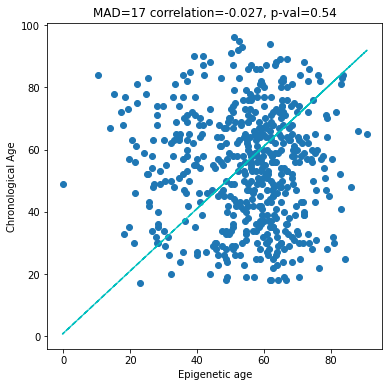

In [54]:
plot_epi_chrono(pred_age_AltumAge_renormed, chrono_age)

#### With BMIQ normalization:

In [55]:
data_meta = pd.read_csv('data/covidGSE167202_meta.csv')
data_norm = pd.read_csv('data/covidGSE167202_normalized.csv')

data_norm = data_norm[AltumAge_cpgs]
methylation_data_scaled = scaler.transform(data_norm)
pred_age_AltumAge = AltumAge.predict(methylation_data_scaled).flatten()

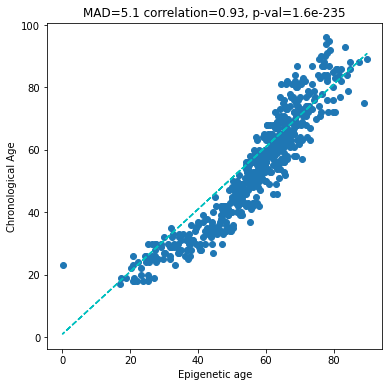

In [56]:
plot_epi_chrono(pred_age_AltumAge, chrono_age)

#### Saving meta data file with AltumAge epigenetic age:

In [57]:
diffs = np.array(pred_age_AltumAge) - np.array(chrono_age)

In [58]:
diffs = np.array(pred_age_AltumAge) - np.array(chrono_age)
data = data_meta.filter(['title','geo_accession',
                        'covid_status:ch1','severity score:ch1','patient_asymptomatic:ch1',
                        'admitted_to_icu:ch1','covid_hosp_days:ch1','discharged_to:ch1','ed_disposition:ch1',
                        'ethnicity:ch1','race:ch1','Sex:ch1',
                        'age:ch1']).copy()
data['epi_bio_age'] = pred_age_AltumAge
data['diffs'] = diffs   

In [59]:
data.to_csv('data_with_epi_age.csv', index=False)

#### Data preview:

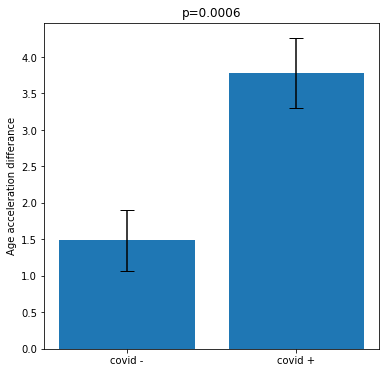

In [61]:
covid_negative = diffs[data['covid_status:ch1'] == 'negative']
covid_positive = diffs[data['covid_status:ch1'] == 'positive']


p_val = stats.ttest_ind(covid_negative, covid_positive).pvalue

covid_negative_dev = stats.sem(covid_negative)
covid_positive_dev = stats.sem(covid_positive)
yer = [covid_negative_dev,covid_positive_dev]

covid_negative_mean = np.mean(covid_negative)
covid_positive_mean = np.mean(covid_positive)

height = [covid_negative_mean,covid_positive_mean]
bars = ['covid -', 'covid +']
y_pos = [1,2]

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(y_pos, height, yerr=yer, capsize=7)
plt.xticks(y_pos, bars)
plt.ylabel('Age acceleration differance')
ax.set_title(('p={:.2g}').format(p_val))
plt.show()